First, we will import all the libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering


Then we read the file. We also display all the columns to take a brief look at what we are dealing with.

In [2]:
df=pd.read_csv('shopEasy.csv')
df.head()

,personId,accountTotal,frequencyIndex,itemCosts,singleItemCosts,multipleItemCosts,emergencyFunds,itemBuyFrequency,singleItemBuyFrequency,multipleItemBuyFrequency,...,emergencyCount,itemCount,maxSpendLimit,monthlyPaid,leastAmountPaid,paymentCompletionRate,accountLifespan,location,accountType,webUsage
0,C10573,1034.660626,0.833333,1308.11,1308.11,0.00,234.602843,0.500000,0.500000,0.000000,...,1,8,1500.0,236.764555,207.007715,0.00,6,New York,Premium,60
1,C16889,777.853474,0.666667,0.00,0.00,0.00,1820.143378,0.000000,0.000000,0.000000,...,8,0,2000.0,89.741508,173.276205,0.00,6,Los Angeles,Premium,5
2,C12964,97.453056,0.818182,334.73,334.73,0.00,19.551802,0.083333,0.083333,0.000000,...,1,1,2500.0,234.271939,117.297542,0.25,12,New York,Student,21
3,C11171,0.000000,0.000000,12.65,0.00,12.65,0.000000,0.083333,0.000000,0.083333,...,0,1,5000.0,0.000000,NaN,0.00,12,Chicago,Premium,53
4,C17582,18.120946,0.500000,57.00,57.00,0.00,0.000000,0.166667,0.166667,0.000000,...,0,1,1500.0,118.438703,54.138711,0.00,6,New York,Premium,59


In [3]:
duplicates = df.duplicated(subset='personId')
print("Duplicate Rows based on 'personId':", df[duplicates])

Duplicate Rows based on 'personId': Empty DataFrame
Columns: [personId, accountTotal, frequencyIndex, itemCosts, singleItemCosts, multipleItemCosts, emergencyFunds, itemBuyFrequency, singleItemBuyFrequency, multipleItemBuyFrequency, emergencyUseFrequency, emergencyCount, itemCount, maxSpendLimit, monthlyPaid, leastAmountPaid, paymentCompletionRate, accountLifespan, location, accountType, webUsage]
Index: []

[0 rows x 21 columns]


Since we have an empty dataframe for duplicates, we know that there are no duplicates (multiple entries of the same customer) and therefore, we don't have to worry about removing duplicates.

In [4]:
df.shape
df.info()
#we 3 categorical variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   personId                  8950 non-null   object 
 1   accountTotal              8950 non-null   float64
 2   frequencyIndex            8950 non-null   float64
 3   itemCosts                 8950 non-null   float64
 4   singleItemCosts           8950 non-null   float64
 5   multipleItemCosts         8950 non-null   float64
 6   emergencyFunds            8950 non-null   float64
 7   itemBuyFrequency          8950 non-null   float64
 8   singleItemBuyFrequency    8950 non-null   float64
 9   multipleItemBuyFrequency  8950 non-null   float64
 10  emergencyUseFrequency     8950 non-null   float64
 11  emergencyCount            8950 non-null   int64  
 12  itemCount                 8950 non-null   int64  
 13  maxSpendLimit             8949 non-null   float64
 14  monthlyP

We see that there is no need to deal with nulls because all are values are 'non-nulls'. We also notice that there are 3 categorical variables - personID (which isn't really necessary) location and account type with their datatype as 'object'. Rest of the variables are continuous seen by there datatype of 'float' and 'int'.

We drop columns that are of no use to us in this analysis i.e. our aim to segment customers to identify their buying patterns and behaviour.

In [5]:
remove = ['personId', 'emergencyFunds', 'emergencyUseFrequency', 'emergencyCount', 'leastAmountPaid'] 
# This is self-explanatory, no need for personaID or emergencyfunds and any attribute associated with it. 
# We also delete leastamountpaid as it cannot solely define a customer's buying behaviour 
# (not a reflection of their income, maybe they just needed something that was affordable!)

We then check if itemCosts is simply singleCosts + multipleCosts.

In [6]:
df['totalItemCosts'] = df['singleItemCosts'] + df['multipleItemCosts']
correlation = round(df[['itemCosts', 'totalItemCosts']].corr())

print(correlation)

df['totalBuyFrequency'] = df['singleItemBuyFrequency'] + df['multipleItemBuyFrequency']
correlation = round(df[['itemBuyFrequency', 'totalBuyFrequency']].corr())

print(correlation)

                itemCosts  totalItemCosts
itemCosts             1.0             1.0
totalItemCosts        1.0             1.0
                   itemBuyFrequency  totalBuyFrequency
itemBuyFrequency                1.0                1.0
totalBuyFrequency               1.0                1.0


The perfect correlations show us that there is no need for singleItems and multipleItems to be present individually. Same goes for their frequency.

In [7]:
remove.extend(['singleItemCosts', 'multipleItemCosts', 'singleItemBuyFrequency', 'multipleItemBuyFrequency'])

Now, we check  if monthlyPaid is derived from accountTotal and the number of months (accountLifespan, assuming it's measured in months).

In [8]:
# Assuming accountLifespan is in months and it's never zero
df['calculatedMonthlyPaid'] = df['accountTotal'] / df['accountLifespan']

# Compare calculatedMonthlyPaid with monthlyPaid
similar = (abs(df['calculatedMonthlyPaid'] - df['monthlyPaid']) < 0.01).all()

print("Is 'monthlyPaid' derived from 'accountTotal' divided by 'accountLifespan'? ", similar)

Is 'monthlyPaid' derived from 'accountTotal' divided by 'accountLifespan'?  False


As we can see, we cannot interpret monthlyPaid as accountTotal divided by accountLifespan. Therefore, we choose to keep it.

We remove all the unnecessary columns as we found.

In [9]:
df = df.drop(columns=remove)

In [10]:
df.shape

(8950, 15)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   accountTotal           8950 non-null   float64
 1   frequencyIndex         8950 non-null   float64
 2   itemCosts              8950 non-null   float64
 3   itemBuyFrequency       8950 non-null   float64
 4   itemCount              8950 non-null   int64  
 5   maxSpendLimit          8949 non-null   float64
 6   monthlyPaid            8950 non-null   float64
 7   paymentCompletionRate  8950 non-null   float64
 8   accountLifespan        8950 non-null   int64  
 9   location               8950 non-null   object 
 10  accountType            8950 non-null   object 
 11  webUsage               8950 non-null   int64  
 12  totalItemCosts         8950 non-null   float64
 13  totalBuyFrequency      8950 non-null   float64
 14  calculatedMonthlyPaid  8950 non-null   float64
dtypes: f

We perform encoding on our categorical variables to numerically represent them; but before that we find the continuous variables which will be helpful for us to deal with them later (in the Univariate analysis).

In [12]:
def find_continuous_variables(df):
    continuous_vars = df.select_dtypes(include=['float', 'int']).columns.tolist()
    return continuous_vars

# Identify continuous variables
continuous_variables = find_continuous_variables(df)

In [13]:
df['accountType'] = df['accountType'].apply(lambda x: 0 if x == 'Regular' else (1 if x == 'Student' else 2))
df['location'] = df['location'].apply(lambda x: 1 if x == 'New York' else (2 if x == 'Los Angeles' else 3))

In [14]:
df.head()

,accountTotal,frequencyIndex,itemCosts,itemBuyFrequency,itemCount,maxSpendLimit,monthlyPaid,paymentCompletionRate,accountLifespan,location,accountType,webUsage,totalItemCosts,totalBuyFrequency,calculatedMonthlyPaid
0,1034.660626,0.833333,1308.11,0.500000,8,1500.0,236.764555,0.00,6,1,2,60,1308.11,0.500000,172.443438
1,777.853474,0.666667,0.00,0.000000,0,2000.0,89.741508,0.00,6,2,2,5,0.00,0.000000,129.642246
2,97.453056,0.818182,334.73,0.083333,1,2500.0,234.271939,0.25,12,1,1,21,334.73,0.083333,8.121088
3,0.000000,0.000000,12.65,0.083333,1,5000.0,0.000000,0.00,12,3,2,53,12.65,0.083333,0.000000
4,18.120946,0.500000,57.00,0.166667,1,1500.0,118.438703,0.00,6,1,2,59,57.00,0.166667,3.020158


In [15]:
df.shape

(8950, 15)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   accountTotal           8950 non-null   float64
 1   frequencyIndex         8950 non-null   float64
 2   itemCosts              8950 non-null   float64
 3   itemBuyFrequency       8950 non-null   float64
 4   itemCount              8950 non-null   int64  
 5   maxSpendLimit          8949 non-null   float64
 6   monthlyPaid            8950 non-null   float64
 7   paymentCompletionRate  8950 non-null   float64
 8   accountLifespan        8950 non-null   int64  
 9   location               8950 non-null   int64  
 10  accountType            8950 non-null   int64  
 11  webUsage               8950 non-null   int64  
 12  totalItemCosts         8950 non-null   float64
 13  totalBuyFrequency      8950 non-null   float64
 14  calculatedMonthlyPaid  8950 non-null   float64
dtypes: f

As there are no 'object's, we can conclude that we were successful with our encoding for our categorical variables.

Our goal with this project is to perform segmentation. We first keep our focus on categorical variables as they are easy to segment. We start with making a simple frequency bar graph.

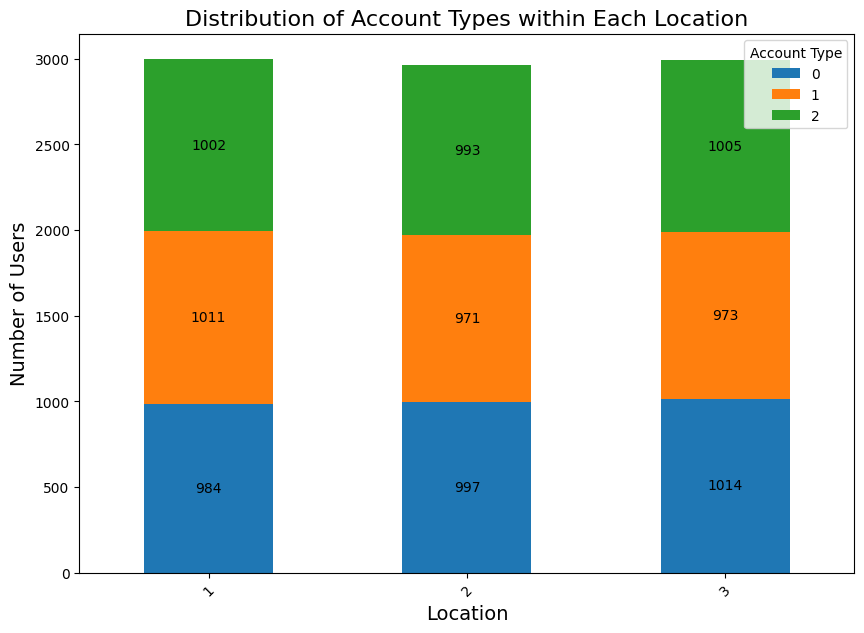

In [17]:
summary_df = df.groupby(['location', 'accountType']).size().unstack(fill_value=0)

# Plotting
ax = summary_df.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Distribution of Account Types within Each Location', fontsize=16)
plt.xlabel('Location', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Account Type')

# Annotate each segment of the stacked bar
for n, bar in enumerate(ax.patches):
    # The text annotation for each bar
    text = int(bar.get_height())
    if text == 0:
        continue  # Skip empty bars
    # Positioning the text
    ax.text(bar.get_x() + bar.get_width() / 2, 
            bar.get_y() + bar.get_height() / 2, 
            text, ha='center', va='center', color='black', fontsize=10)

plt.show()


We notice that this distribution is fairly even. This is a good thing as we now should not be worried about scaling this data. Now, let's introduce some filters to understand this data better in terms of customer buying behaviour and thereby, make appropriate interpretations.

**Filter by Spending Levels - Account Total**

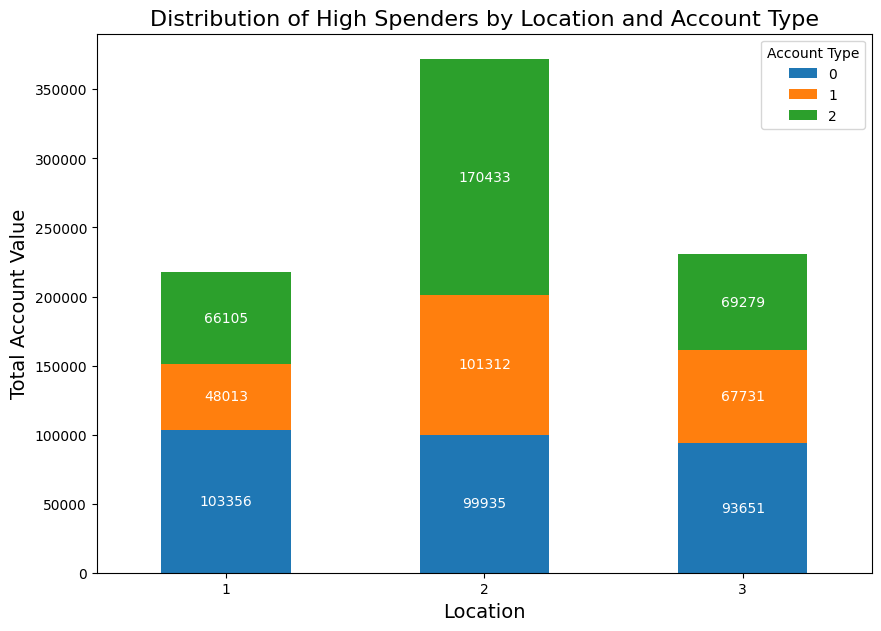

In [18]:
high_spenders = df[df['accountTotal'] > 10000]

# Pivot the data to get the sum of accountTotal for each location and accountType combination
pivot_df = high_spenders.pivot_table(values='accountTotal', index='location', columns='accountType', aggfunc='sum', fill_value=0)

pivot_df.plot(kind='bar', stacked=True, figsize=(10, 7))

# Customize the plot with titles and labels
plt.title('Distribution of High Spenders by Location and Account Type', fontsize=16)
plt.xlabel('Location', fontsize=14)
plt.ylabel('Total Account Value', fontsize=14)
plt.xticks(rotation=0)  # Set rotation for an even view
plt.legend(title='Account Type')

# Annotate the bars
for n, x in enumerate([*pivot_df.index.values]):
    for (proportion, y_loc, account_type) in zip(pivot_df.loc[x],
                                                  pivot_df.loc[x].cumsum(),
                                                  pivot_df.columns):
        plt.text(x=n,  # x coordinate (bar location)
                 y=y_loc - proportion/2,  # y coordinate (mid of the bar section)
                 s=f'{int(proportion)}',  # label (rounded to integer)
                 ha='center', 
                 va='center',
                 fontsize=10,
                 color='white')

plt.show()

**Filter by Spending Levels - Monthly Paid**

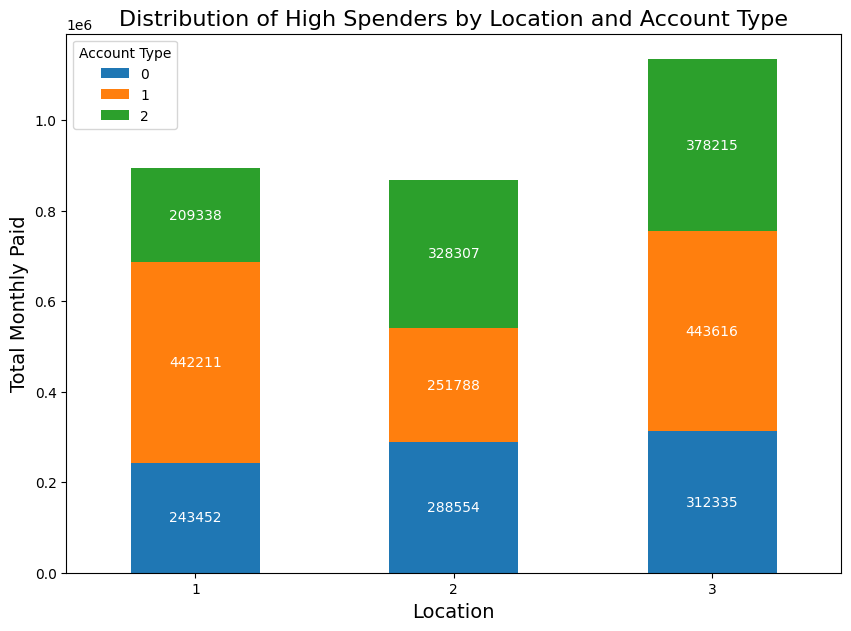

In [19]:
high_spenders = df[df['monthlyPaid'] > 10000]

# Create a pivot table with the sum of 'monthlyPaid' for each location and accountType combination
pivot_df = high_spenders.pivot_table(values='monthlyPaid', index='location', columns='accountType', aggfunc='sum', fill_value=0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 7))

# Customize the plot with titles and labels
plt.title('Distribution of High Spenders by Location and Account Type', fontsize=16)
plt.xlabel('Location', fontsize=14)
plt.ylabel('Total Monthly Paid', fontsize=14)
plt.xticks(rotation=0)  # Set rotation for an even view
plt.legend(title='Account Type')

# Annotate the bars with the summed monthly payment values
for n, x in enumerate([*pivot_df.index.values]):
    for (proportion, y_loc) in zip(pivot_df.loc[x], pivot_df.loc[x].cumsum()):
        if proportion > 0:  # Only annotate non-zero values
            plt.text(x=n,  # x coordinate (bar location)
                     y=y_loc - proportion/2,  # y coordinate (mid of the bar section)
                     s=f'{int(proportion)}',  # label (rounded to integer)
                     ha='center', 
                     va='center',
                     fontsize=10,
                     color='white')

plt.show()

**Filter by Purchase Frequency - frequencyIndex**

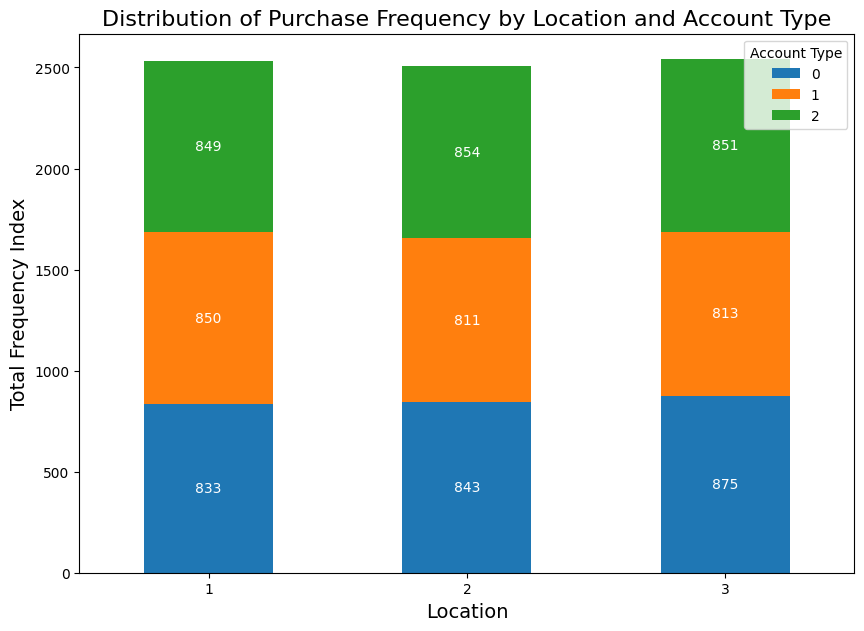

In [20]:
high_spenders = df[df['frequencyIndex'] > 0.5]

# Create a pivot table with the sum of 'monthlyPaid' for each location and accountType combination
pivot_df = high_spenders.pivot_table(values='frequencyIndex', index='location', columns='accountType', aggfunc='sum', fill_value=0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 7))

# Customize the plot with titles and labels
plt.title('Distribution of Purchase Frequency by Location and Account Type', fontsize=16)
plt.xlabel('Location', fontsize=14)
plt.ylabel('Total Frequency Index', fontsize=14)
plt.xticks(rotation=0)  # Set rotation for an even view
plt.legend(title='Account Type')

# Annotate the bars with the summed monthly payment values
for n, x in enumerate([*pivot_df.index.values]):
    for (proportion, y_loc) in zip(pivot_df.loc[x], pivot_df.loc[x].cumsum()):
        if proportion > 0:  # Only annotate non-zero values
            plt.text(x=n,  # x coordinate (bar location)
                     y=y_loc - proportion/2,  # y coordinate (mid of the bar section)
                     s=f'{int(proportion)}',  # label (rounded to integer)
                     ha='center', 
                     va='center',
                     fontsize=10,
                     color='white')

plt.show()

**Filter by Purchase Frequency - itemBuyFrequency**

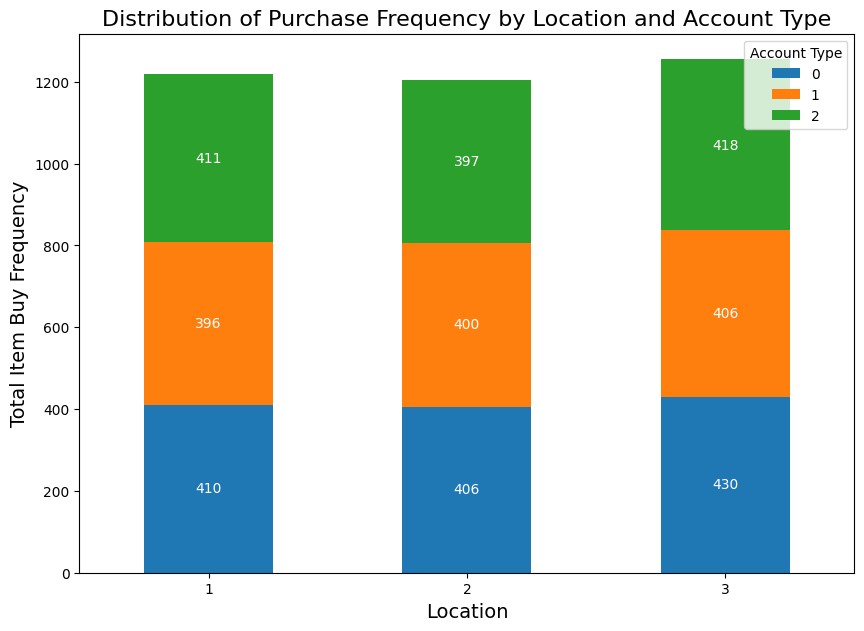

In [21]:
high_spenders = df[df['itemBuyFrequency'] > 0.5]

# Create a pivot table with the sum of 'monthlyPaid' for each location and accountType combination
pivot_df = high_spenders.pivot_table(values='itemBuyFrequency', index='location', columns='accountType', aggfunc='sum', fill_value=0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 7))

# Customize the plot with titles and labels
plt.title('Distribution of Purchase Frequency by Location and Account Type', fontsize=16)
plt.xlabel('Location', fontsize=14)
plt.ylabel('Total Item Buy Frequency', fontsize=14)
plt.xticks(rotation=0)  # Set rotation for an even view
plt.legend(title='Account Type')

# Annotate the bars with the summed monthly payment values
for n, x in enumerate([*pivot_df.index.values]):
    for (proportion, y_loc) in zip(pivot_df.loc[x], pivot_df.loc[x].cumsum()):
        if proportion > 0:  # Only annotate non-zero values
            plt.text(x=n,  # x coordinate (bar location)
                     y=y_loc - proportion/2,  # y coordinate (mid of the bar section)
                     s=f'{int(proportion)}',  # label (rounded to integer)
                     ha='center', 
                     va='center',
                     fontsize=10,
                     color='white')

plt.show()

Now, let's coduct Univariate Analysis for the continuous variables.

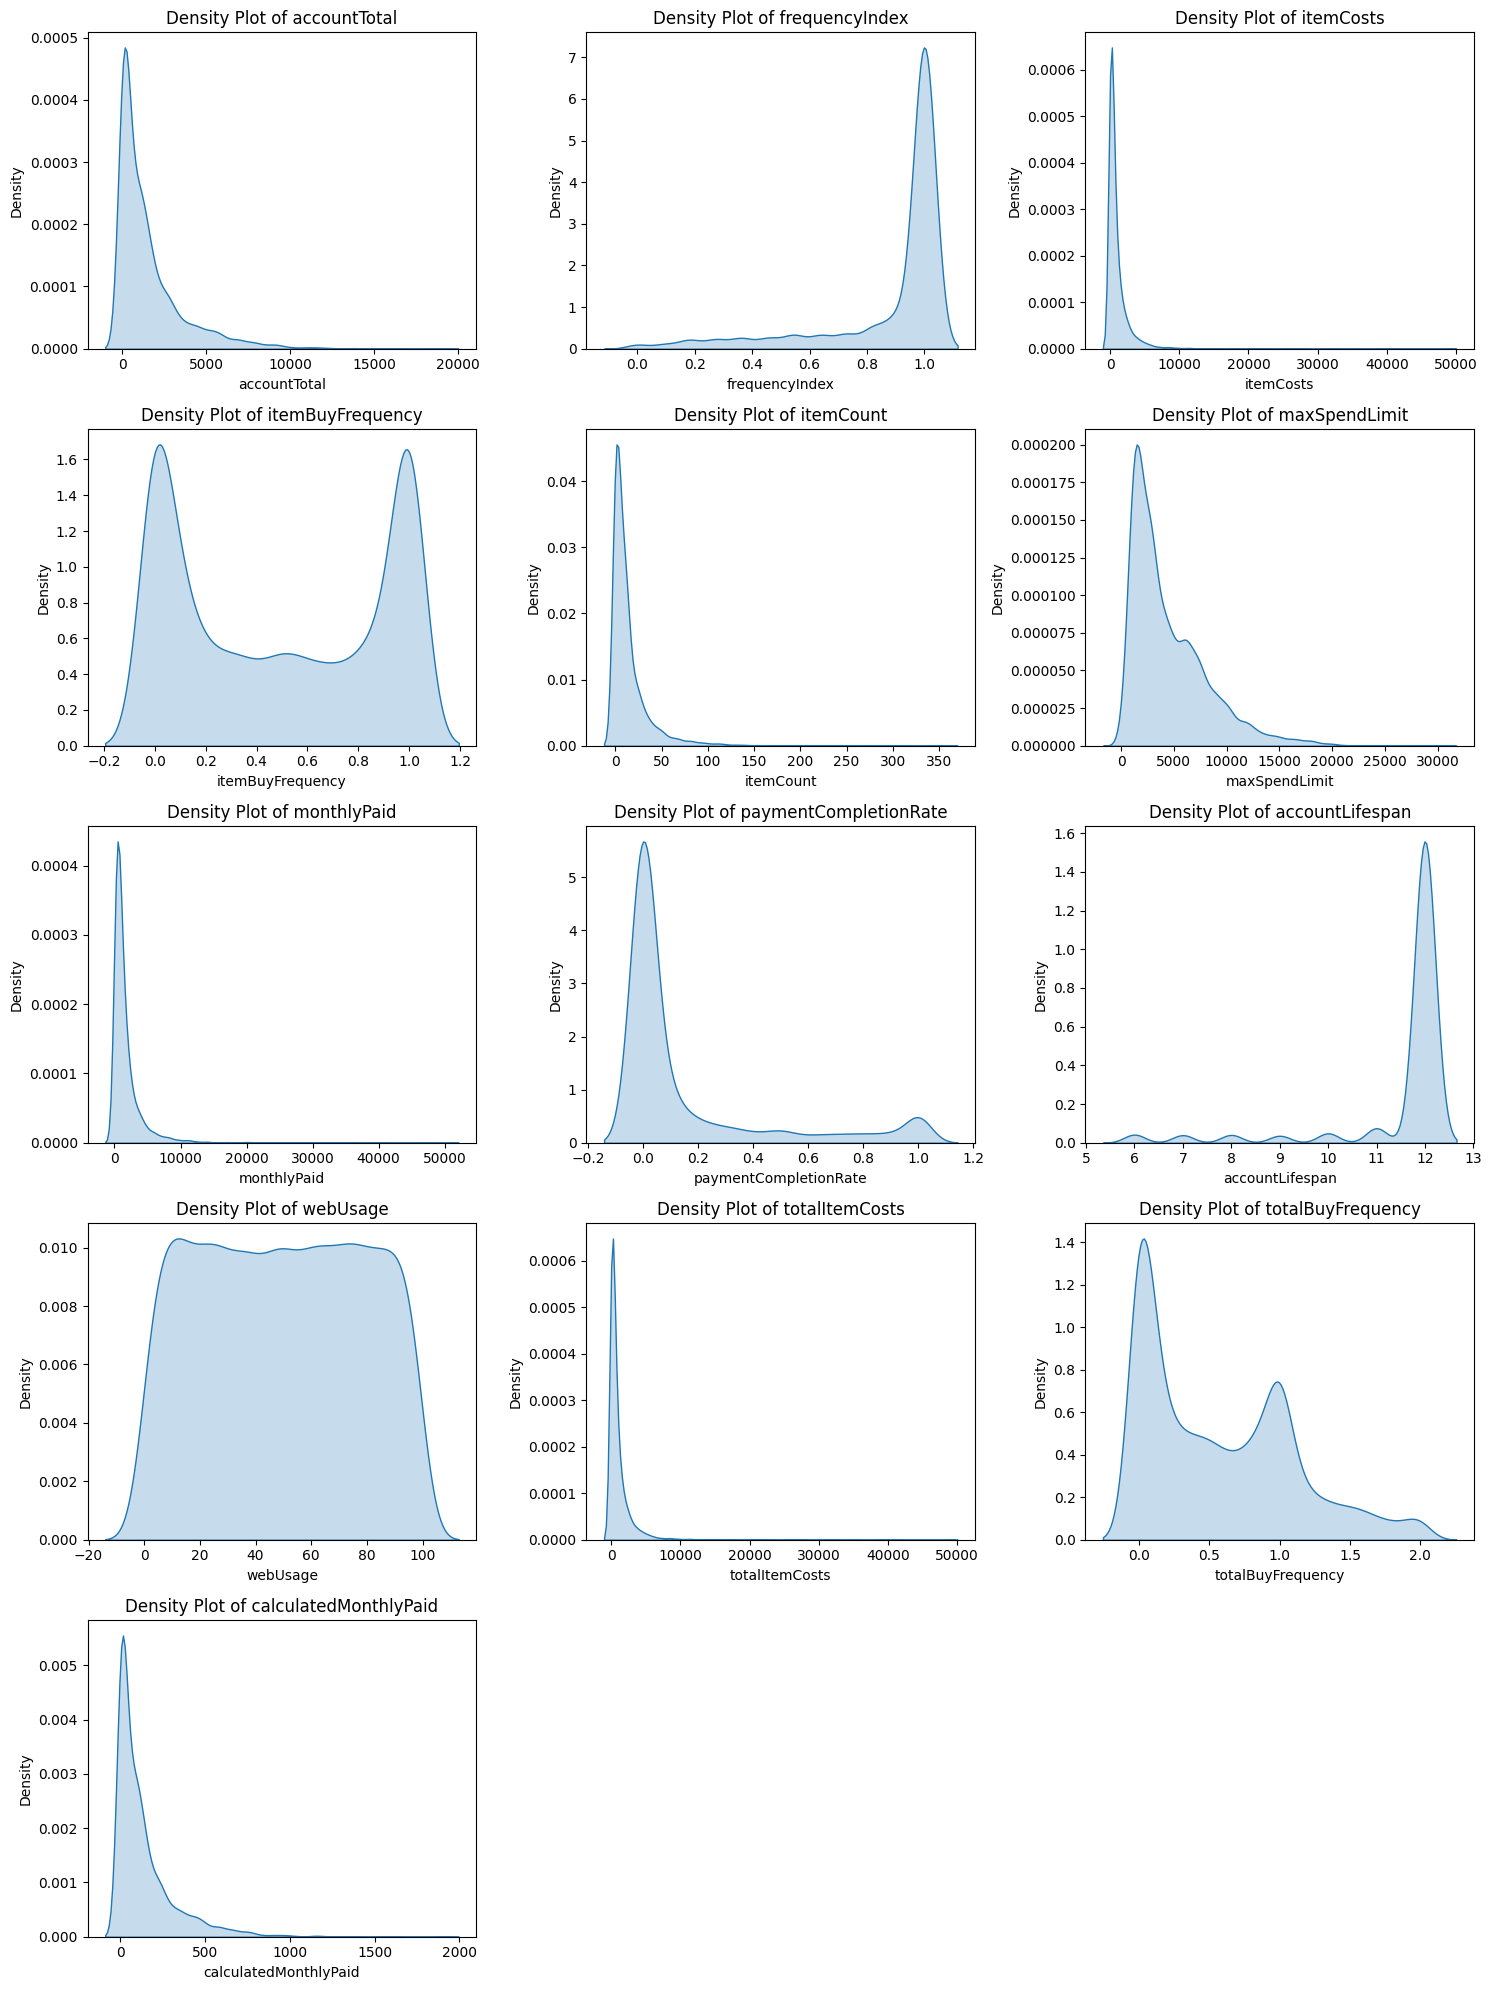

In [22]:
plt.figure(figsize=(15, 20))  # Adjust figure size as needed

num_vars = len(continuous_variables)
num_columns = 3  
num_rows = (num_vars + num_columns - 1) // num_columns  # Calculate rows needed

for i, var in enumerate(continuous_variables, 1):
    plt.subplot(num_rows, num_columns, i)
    sns.kdeplot(df[var], fill=True)
    plt.title(f'Density Plot of {var}')

plt.tight_layout()
plt.show()

Now, we converge our focus to the two most important columns in our dataset - the frequencyIndex and the accountTotal. Both of these are highly important as how frequent a customer makes purchases and the amount of spending he does are key factors in determining the customers' behaviour highlighting aspects like loyalty. We combine these two scores into one composite metric. We first normalise the data as we are dealing with two columns at different scales.

 We then follow it up with a correlation analysis. 

In [23]:
scaler = MinMaxScaler()
df[['normalized_frequency', 'normalized_total']] = scaler.fit_transform(df[['frequencyIndex', 'accountTotal']])
# Weights for each metric
# here the weights are taken as a percentage so 0.5 from both add to 1 which is the total.
weight_frequency = 0.5  # Weight for frequency
weight_total = 0.5      # Weight for total spend
df['composite_score'] = (df['normalized_frequency'] * weight_frequency) + (df['normalized_total'] * weight_total)
df.drop(['normalized_frequency', 'normalized_total'], axis=1, inplace=True)


In [24]:
df.head()

,accountTotal,frequencyIndex,itemCosts,itemBuyFrequency,itemCount,maxSpendLimit,monthlyPaid,paymentCompletionRate,accountLifespan,location,accountType,webUsage,totalItemCosts,totalBuyFrequency,calculatedMonthlyPaid,composite_score
0,1034.660626,0.833333,1308.11,0.500000,8,1500.0,236.764555,0.00,6,1,2,60,1308.11,0.500000,172.443438,0.443833
1,777.853474,0.666667,0.00,0.000000,0,2000.0,89.741508,0.00,6,2,2,5,0.00,0.000000,129.642246,0.353757
2,97.453056,0.818182,334.73,0.083333,1,2500.0,234.271939,0.25,12,1,1,21,334.73,0.083333,8.121088,0.411650
3,0.000000,0.000000,12.65,0.083333,1,5000.0,0.000000,0.00,12,3,2,53,12.65,0.083333,0.000000,0.000000
4,18.120946,0.500000,57.00,0.166667,1,1500.0,118.438703,0.00,6,1,2,59,57.00,0.166667,3.020158,0.250476


We make a correlation heatmap.

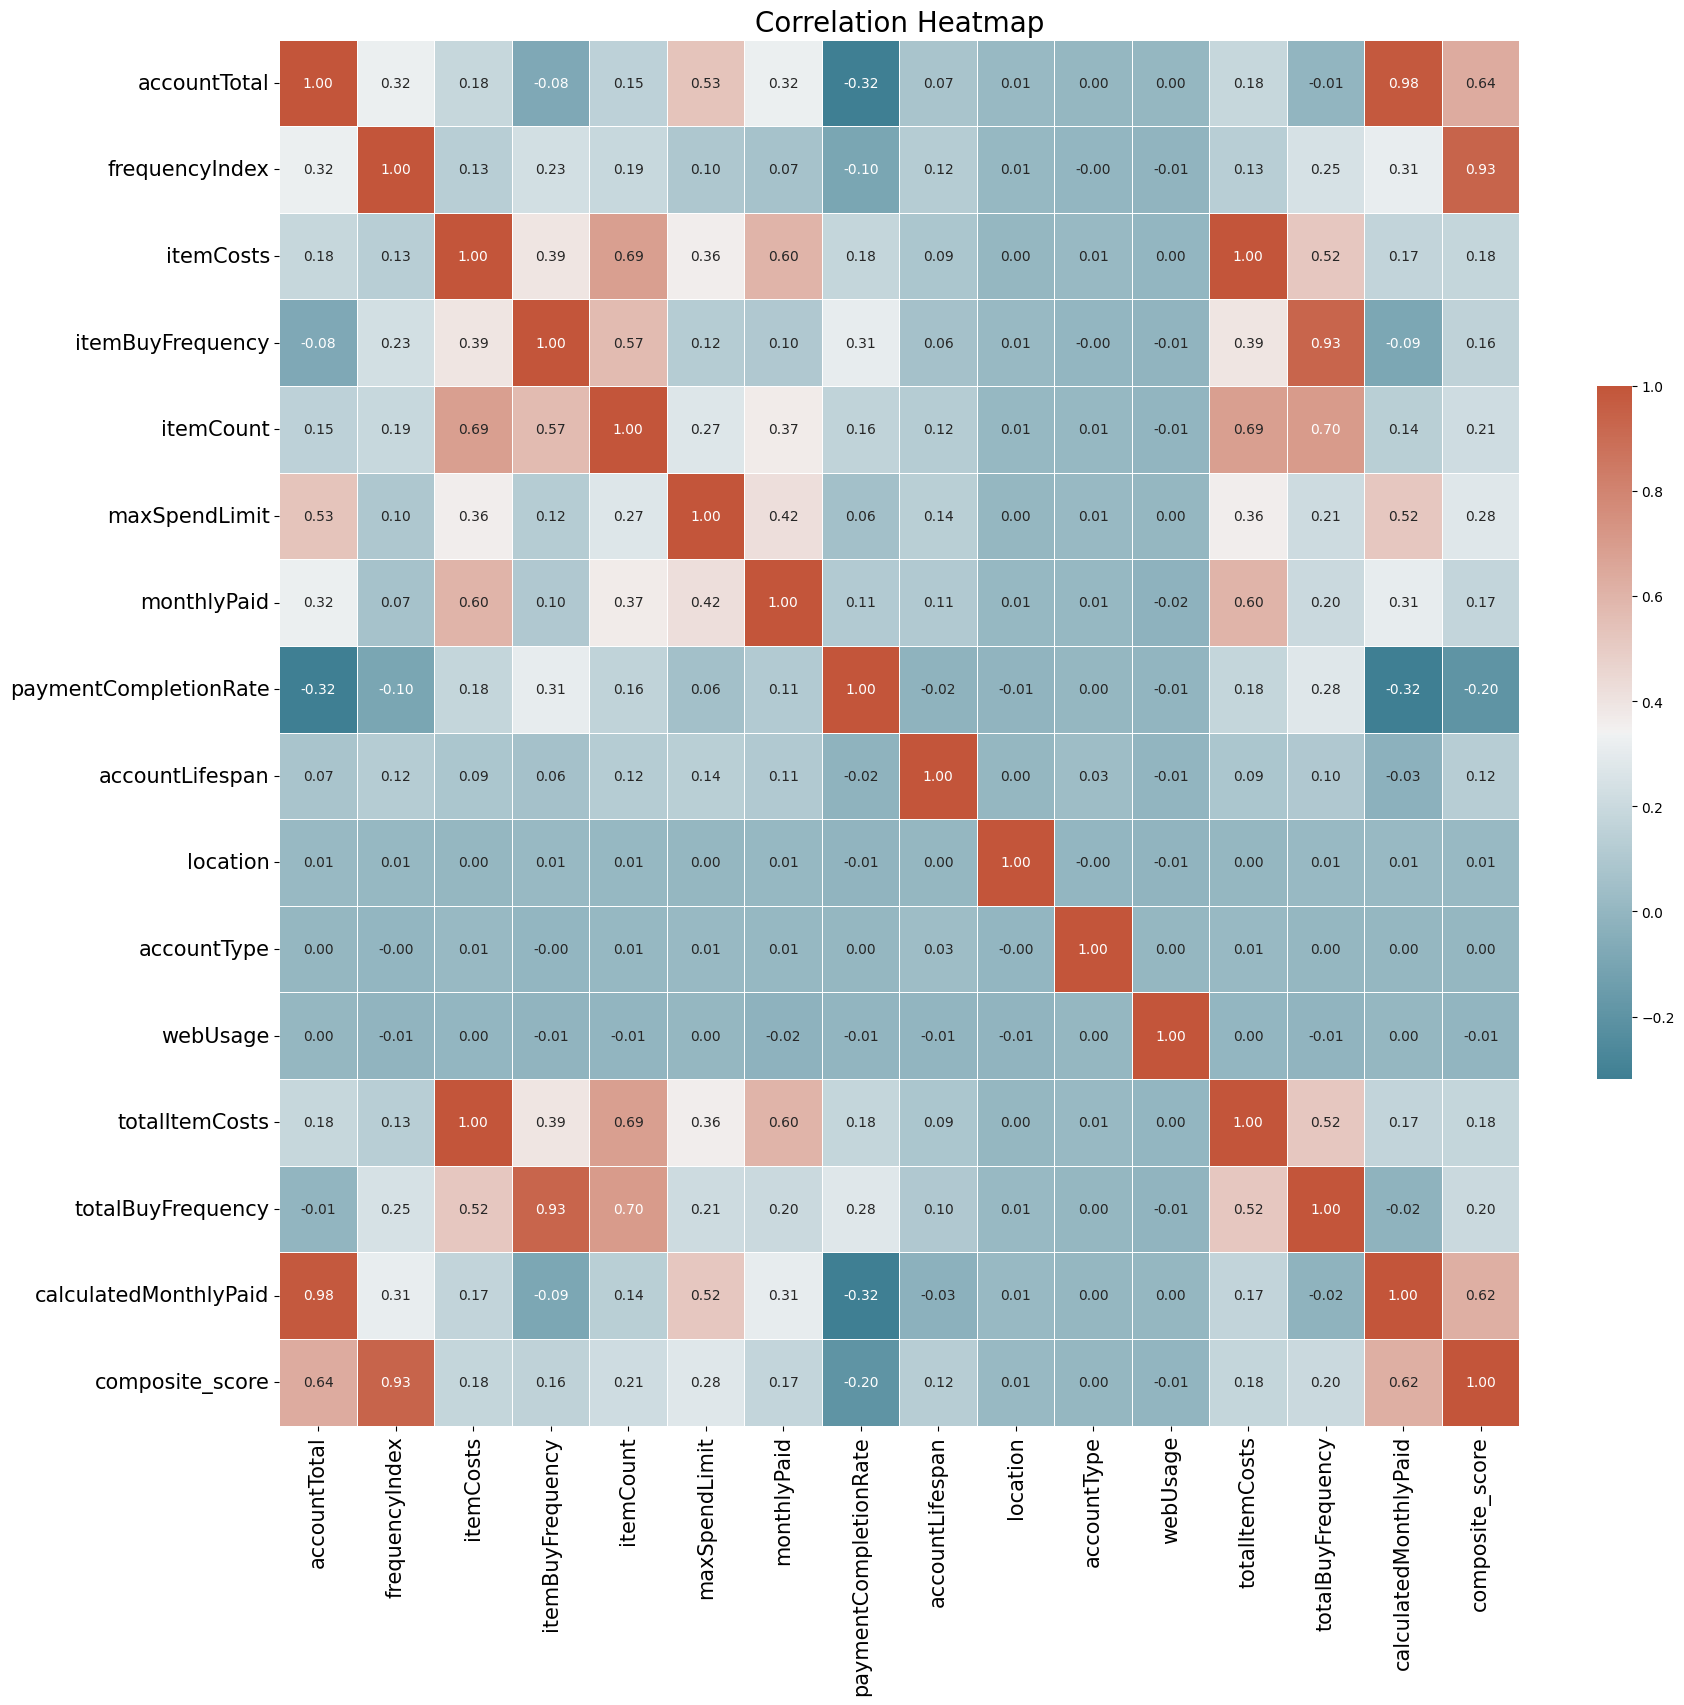

In [25]:
correlation_matrix = df.corr()

plt.figure(figsize=(20, 18))

cmap = sns.diverging_palette(220, 20, as_cmap=True)

ax = sns.heatmap(correlation_matrix, cmap=cmap, annot=True, fmt=".2f",
                 linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=90, fontsize=15)  # Rotate x-axis labels
plt.yticks(rotation=0, fontsize=15)  # Adjust y-axis labels
plt.title('Correlation Heatmap', fontsize=20)  
plt.show()

In [26]:
df.corr().frequencyIndex.sort_values()

paymentCompletionRate   -0.095082
webUsage                -0.012567
accountType             -0.000716
location                 0.009547
monthlyPaid              0.065008
maxSpendLimit            0.095843
accountLifespan          0.119776
totalItemCosts           0.133646
itemCosts                0.133674
itemCount                0.189626
itemBuyFrequency         0.229715
totalBuyFrequency        0.246059
calculatedMonthlyPaid    0.311631
accountTotal             0.322412
composite_score          0.934722
frequencyIndex           1.000000
Name: frequencyIndex, dtype: float64

In [27]:
df.corr().accountTotal.sort_values()

paymentCompletionRate   -0.318959
itemBuyFrequency        -0.077944
totalBuyFrequency       -0.006200
webUsage                 0.001721
accountType              0.004358
location                 0.013387
accountLifespan          0.072692
itemCount                0.154338
totalItemCosts           0.181198
itemCosts                0.181261
frequencyIndex           0.322412
monthlyPaid              0.322802
maxSpendLimit            0.531283
composite_score          0.637768
calculatedMonthlyPaid    0.984033
accountTotal             1.000000
Name: accountTotal, dtype: float64

In [28]:
df.corr().composite_score.sort_values()

paymentCompletionRate   -0.197113
webUsage                -0.009579
accountType              0.001054
location                 0.012794
accountLifespan          0.124750
itemBuyFrequency         0.157653
monthlyPaid              0.174084
totalItemCosts           0.176772
itemCosts                0.176818
totalBuyFrequency        0.197886
itemCount                0.212238
maxSpendLimit            0.277513
calculatedMonthlyPaid    0.623000
accountTotal             0.637768
frequencyIndex           0.934722
composite_score          1.000000
Name: composite_score, dtype: float64

It is only natural that the correlation between our composite score and the 'compositions' are sufficiently high. This makes us conclude that oir composite score is a valid representation of both integral columns - frequencyIndex and accountTotal.

We proceed with dropping the columns with a negligible correlation with composite_score (< 0.01)

In [29]:
threshold=0.01
negligible_corr_columns = correlation_matrix.loc[abs(correlation_matrix['composite_score']) < threshold].index

print(negligible_corr_columns)
df.drop('webUsage', axis=1, inplace=True)
continuous_variables

Index(['accountType', 'webUsage'], dtype='object')


['accountTotal',
 'frequencyIndex',
 'itemCosts',
 'itemBuyFrequency',
 'itemCount',
 'maxSpendLimit',
 'monthlyPaid',
 'paymentCompletionRate',
 'accountLifespan',
 'webUsage',
 'totalItemCosts',
 'totalBuyFrequency',
 'calculatedMonthlyPaid']

In [30]:
df.head()

,accountTotal,frequencyIndex,itemCosts,itemBuyFrequency,itemCount,maxSpendLimit,monthlyPaid,paymentCompletionRate,accountLifespan,location,accountType,totalItemCosts,totalBuyFrequency,calculatedMonthlyPaid,composite_score
0,1034.660626,0.833333,1308.11,0.500000,8,1500.0,236.764555,0.00,6,1,2,1308.11,0.500000,172.443438,0.443833
1,777.853474,0.666667,0.00,0.000000,0,2000.0,89.741508,0.00,6,2,2,0.00,0.000000,129.642246,0.353757
2,97.453056,0.818182,334.73,0.083333,1,2500.0,234.271939,0.25,12,1,1,334.73,0.083333,8.121088,0.411650
3,0.000000,0.000000,12.65,0.083333,1,5000.0,0.000000,0.00,12,3,2,12.65,0.083333,0.000000,0.000000
4,18.120946,0.500000,57.00,0.166667,1,1500.0,118.438703,0.00,6,1,2,57.00,0.166667,3.020158,0.250476


We conduct the correlational analysis and univariate analysis again to see how our data has changed after the preprocessing. 

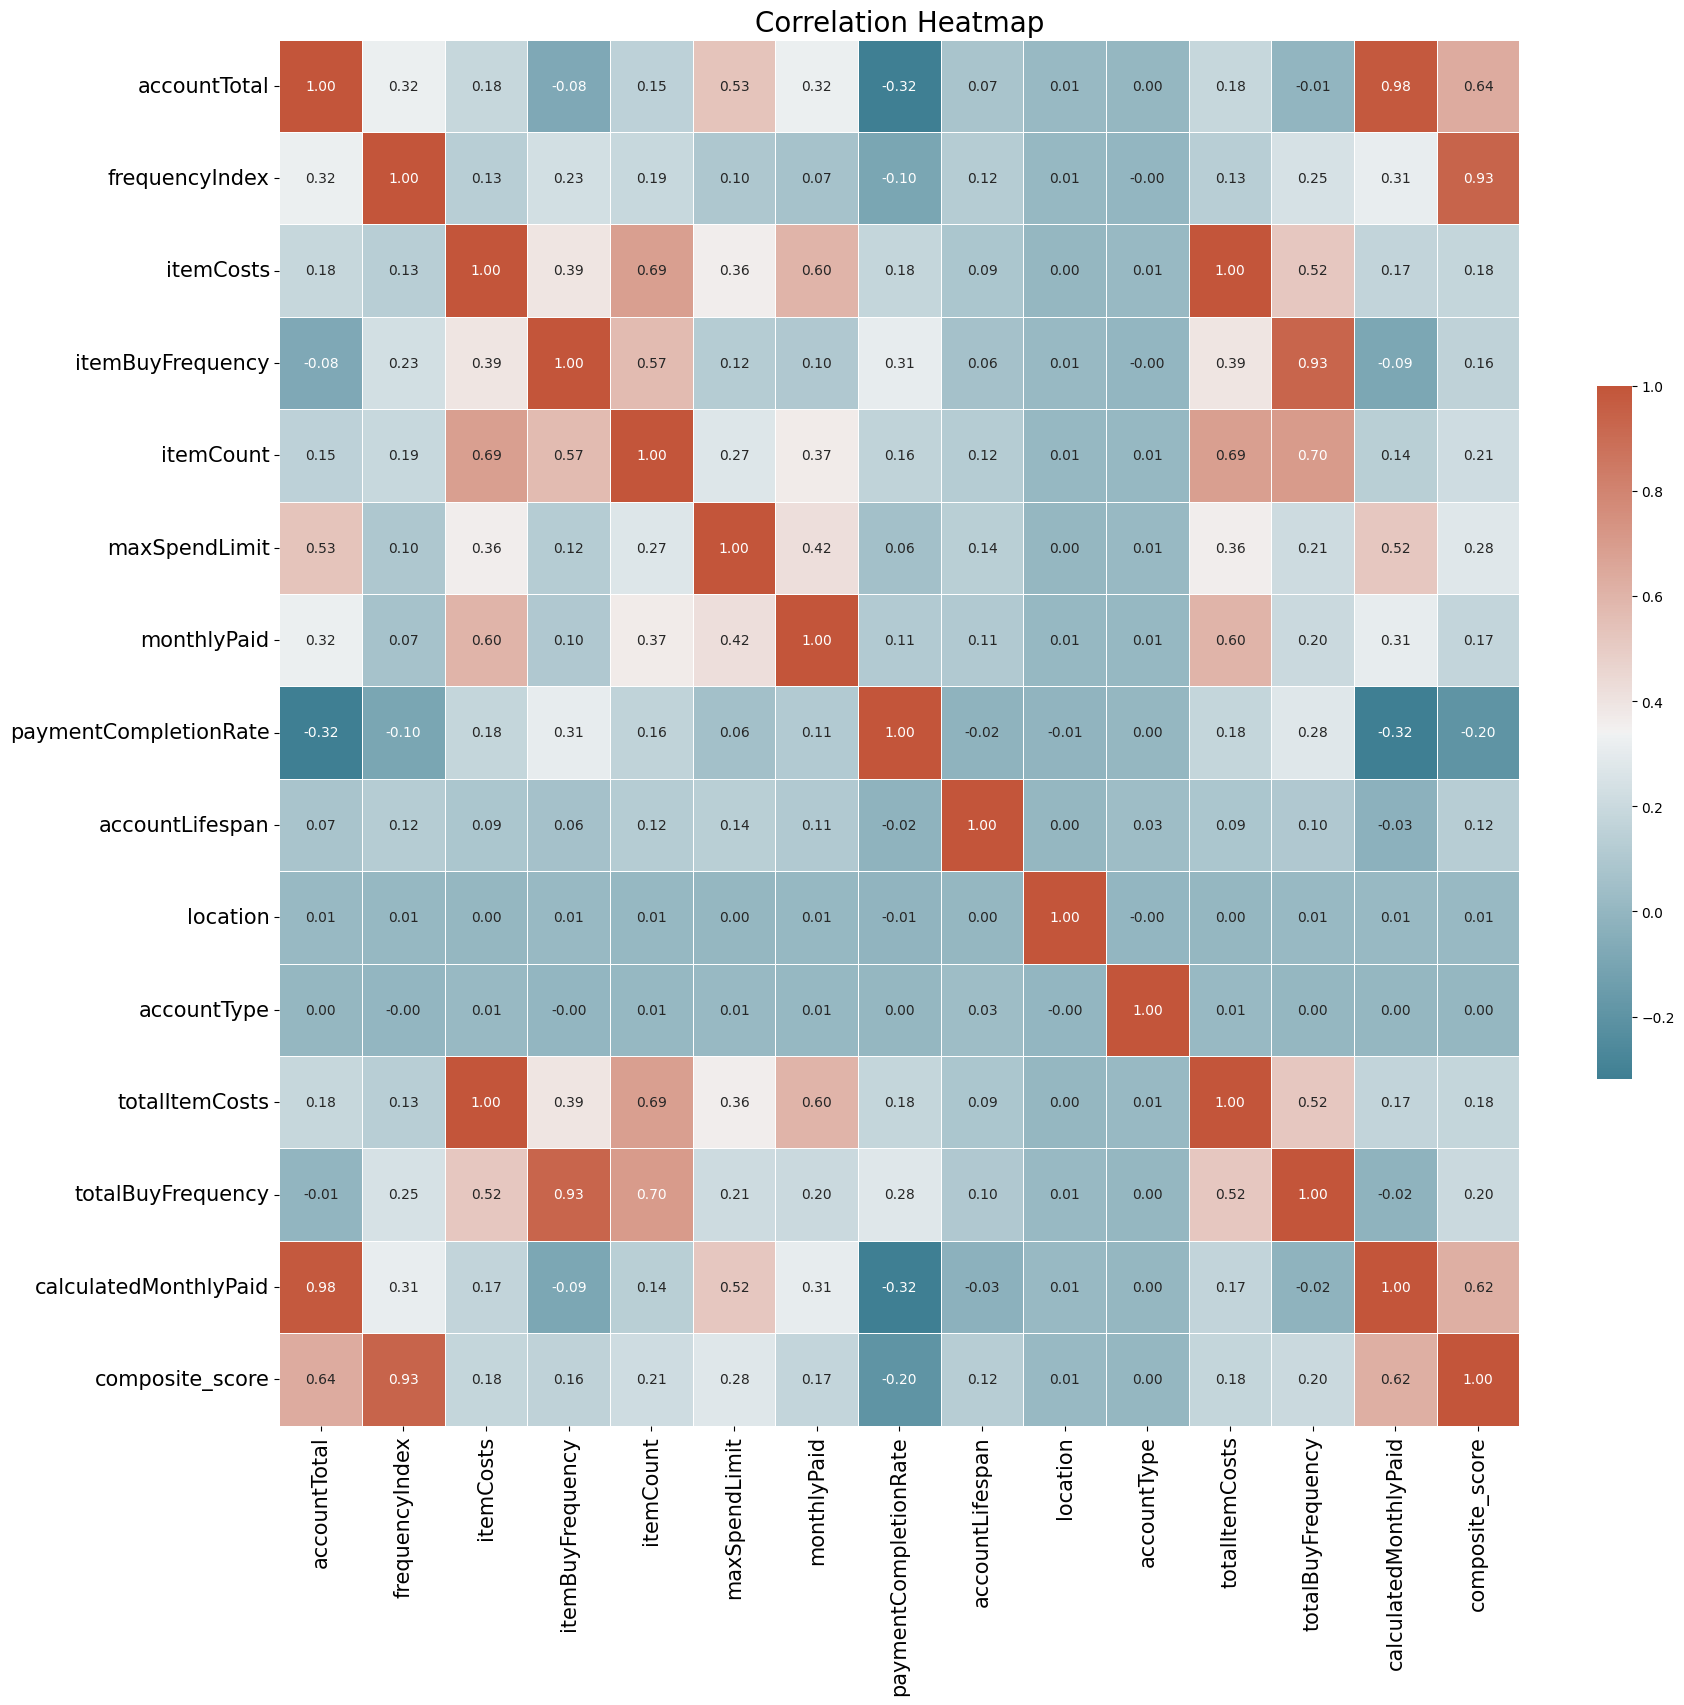

In [31]:
correlation_matrix = df.corr()

plt.figure(figsize=(20, 18))

cmap = sns.diverging_palette(220, 20, as_cmap=True)

ax = sns.heatmap(correlation_matrix, cmap=cmap, annot=True, fmt=".2f",
                 linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=90, fontsize=15)  # Rotate x-axis labels
plt.yticks(rotation=0, fontsize=15)  # Adjust y-axis labels
plt.title('Correlation Heatmap', fontsize=20)  # Add a title to the heatmap
plt.show()

In [32]:
df.corr().composite_score.sort_values()

paymentCompletionRate   -0.197113
accountType              0.001054
location                 0.012794
accountLifespan          0.124750
itemBuyFrequency         0.157653
monthlyPaid              0.174084
totalItemCosts           0.176772
itemCosts                0.176818
totalBuyFrequency        0.197886
itemCount                0.212238
maxSpendLimit            0.277513
calculatedMonthlyPaid    0.623000
accountTotal             0.637768
frequencyIndex           0.934722
composite_score          1.000000
Name: composite_score, dtype: float64

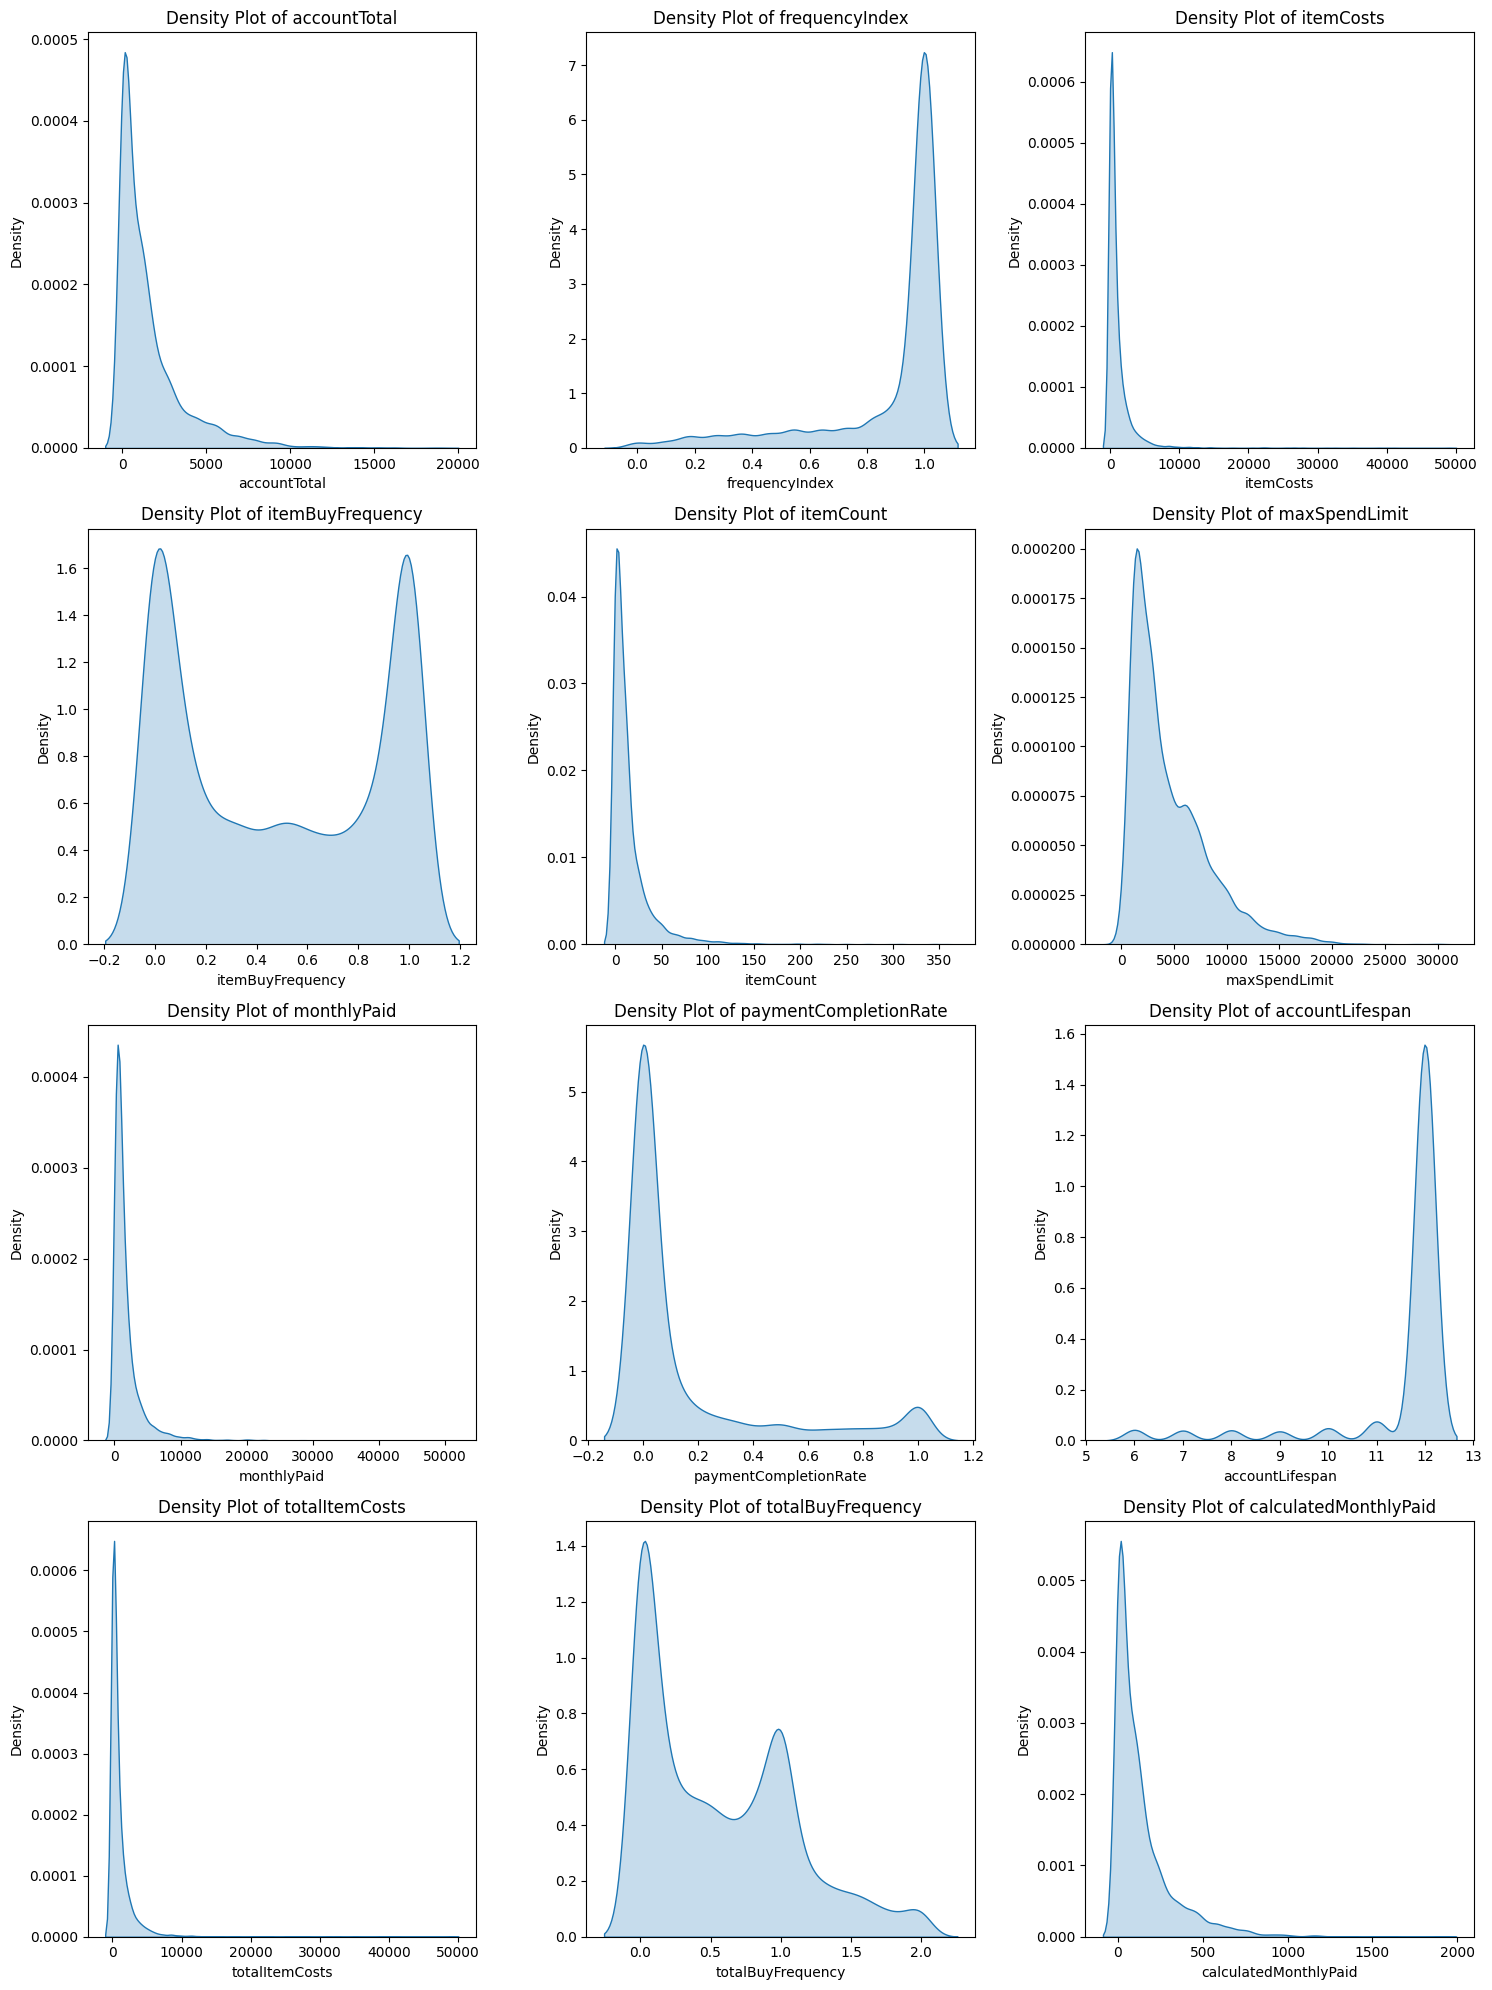

In [33]:
continuous_variables = [var for var in continuous_variables if var not in negligible_corr_columns]

plt.figure(figsize=(15, 20))  # Adjust the figure size as needed
for i, var in enumerate(continuous_variables, 1):
    plt.subplot(4, 3, i)  # Adjust the grid to 4 rows and 3 columns
    sns.kdeplot(df[var], fill=True)
    plt.title(f'Density Plot of {var}')
plt.tight_layout()  # Adjusts the plots to fit into the figure area.
plt.show()


This problem is a Clustering problem since our goal is to find inherent groupings in the data i.e. to segment customers based on their buying habits and behaviors, which defines a classic clustering.

Let's scale our data.

In [34]:
df.fillna(df.mean(), inplace=True)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

**K-Means Clustering**

First, let's find a value of K using Elbow's method of fine tuning.

c:\Users\banuk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\banuk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\banuk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\banuk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

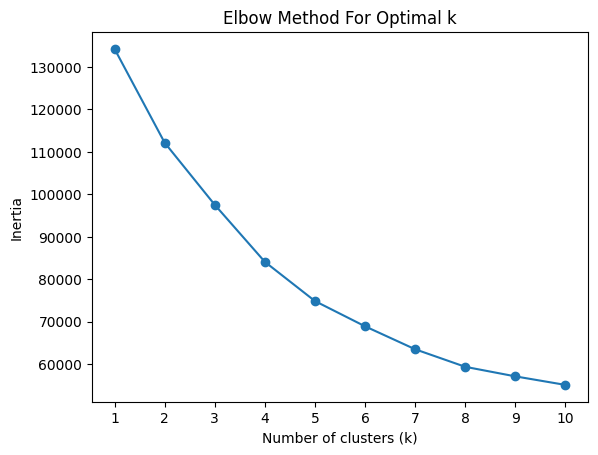

In [35]:
# Calculate the inertia for a range of k values
inertia = []
k_values = range(1, 11)  # Test k from 1 to 10
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(k_values)
plt.show()

We notice that 7 can be called the 'elbow' of this curve since it is the point where the inertia starts to decrease more slowly. Hence, it is appropriate to choose it as our K value.

In [36]:
# Apply K-Means Clustering on the scaled data
k = 7
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(scaled_features)

# If you want to add clusters back to df, ensure df and clusters have the same number of rows
df['cluster'] = clusters

c:\Users\banuk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0:
       accountTotal  frequencyIndex    itemCosts  itemBuyFrequency  \
count   1297.000000     1297.000000  1297.000000       1297.000000   
mean     126.788064        0.375609   353.661218          0.282014   
std      278.694168        0.194167   518.202338          0.274598   
min        0.000000        0.000000     0.000000          0.000000   
25%        7.099375        0.200000    39.540000          0.083333   
50%       25.715061        0.363636   166.320000          0.181818   
75%       98.418953        0.545455   448.740000          0.416667   
max     2891.678357        0.727273  5252.040000          1.000000   

         itemCount  maxSpendLimit   monthlyPaid  paymentCompletionRate  \
count  1297.000000    1297.000000   1297.000000            1297.000000   
mean      4.637625    3863.677289   1244.676019               0.232244   
std       5.573283    3247.817287   2737.433567               0.342024   
min       0.000000     300.000000      0.000000               

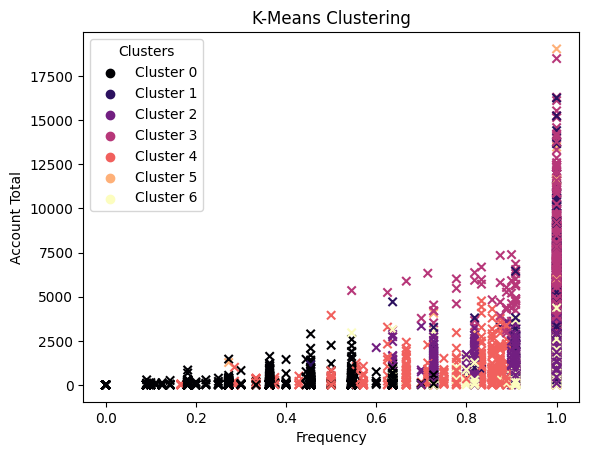

In [37]:
# Summary statistics for each cluster
for i in range(k):
    print(f"Cluster {i}:")
    print(df[df['cluster'] == i].describe())

# Visualization (if your data is 2D or 3D)
plt.scatter(df['frequencyIndex'], df['accountTotal'], c=df['cluster'], cmap='magma', marker="x")
plt.xlabel('Frequency')
plt.ylabel('Account Total')
plt.title('K-Means Clustering')
colors = [plt.cm.magma(each) for each in np.linspace(0, 1, k)]
for i, color in enumerate(colors):
    plt.scatter([], [], c=[color], label=f"Cluster {i}")

plt.legend(title="Clusters")
plt.show()

**Hierarchical Clustering**

In [38]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.mean(), inplace=True)
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
Z = linkage(scaled_df, method='ward')  # Ward's method
dendrogram(Z)
plt.show()

In [ ]:
for i in range(k):
    print(f"Cluster {i}:")
    print(df[df['cluster'] == i].describe())

plt.scatter(df['frequencyIndex'], df['accountTotal'], c=df['cluster'], cmap='magma', marker="x")
plt.legend(title="Clusters")
plt.show()

In [ ]:
kmeans_labels = kmeans.fit_predict(scaled_features)
kmeans_silhouette = silhouette_score(scaled_features, kmeans_labels)

# Apply Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
hc_labels = hc.fit_predict(scaled_features)
hc_silhouette = silhouette_score(scaled_features, hc_labels)

# Print the silhouette scores for comparison
print(f"Silhouette Score for K-Means: {kmeans_silhouette:.2f}")
print(f"Silhouette Score for Hierarchical Clustering: {hc_silhouette:.2f}")

# Visualization
# For K-Means
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=kmeans_labels, cmap='viridis', marker='.')
plt.title('K-Means Clustering')

# For Hierarchical Clustering
plt.subplot(1, 2, 2)
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=hc_labels, cmap='viridis', marker='.')
plt.title('Hierarchical Clustering')

plt.show()

# Determine which method provides a more meaningful segmentation
if kmeans_silhouette > hc_silhouette:
    print("K-Means provides a more meaningful segmentation.")
elif kmeans_silhouette < hc_silhouette:
    print("Hierarchical Clustering provides a more meaningful segmentation.")
else:
    print("Both methods provide similarly meaningful segmentation.")

In [ ]:
df['kmeans_cluster'] = kmeans_labels

# Number of clusters
num_clusters = np.unique(kmeans_labels).size

# Initialize a dictionary to store properties of each cluster
cluster_properties = {}

for i in range(num_clusters):
    # Filter the DataFrame to include only data points assigned to the current cluster
    cluster_data = df[df['kmeans_cluster'] == i]
    
    # Compute summary statistics for the cluster
    stats = cluster_data.describe()
    
    # Store the summary statistics in the dictionary
    cluster_properties[f'Cluster {i}'] = stats

    # Output the summary statistics to describe the properties
    print(f"\nProperties of Cluster {i}:")
    print(stats)
    
    # Alternatively, you could look at median values, or modes for categorical variables
    # You can also assess distributions, variances, etc.

# Now let's print out the cluster properties for each segment
for cluster, properties in cluster_properties.items():
    print(f"\n{cluster} properties (summary):")
    print(properties)


In [ ]:
for cluster_label in df['kmeans_cluster'].unique():
    # Select data for the current cluster
    cluster_data = df[df['kmeans_cluster'] == cluster_label]
    
    # Calculate the mean for all numerical features
    mean_values = cluster_data.mean()
    
    # Initialize a Series to hold the mode values
    mode_values = pd.Series(dtype='object')
    
    # Calculate the mode for all categorical features if you have any
    mode_df = cluster_data.select_dtypes(include=['object']).mode()
    if not mode_df.empty:
        mode_values = mode_df.iloc[0]
    
    # Combine the statistics into a single Series
    cluster_summary = pd.concat([mean_values, mode_values], axis=0)
    
    # Print the properties of each customer segment
    print(f"\nProperties of customers in Cluster {cluster_label}:")
    print(cluster_summary)